In [43]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random

In [3]:
df=pd.read_csv("C:\\Users\\hp\\Documents\\IAFSM_ML\\Naive_K-neighbours\\Dataset\\train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X=df.drop(["Survived","Name","PassengerId","Ticket","Cabin"],axis=1)
Y=df["Survived"]

In [5]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
for col in X.columns: ## Checking for columns with null values
    print(X[col].isna().sum())

0
0
177
0
0
0
2


### Impute  null values with mean value of age

In [8]:
X["Age"]=X["Age"].fillna(29.666)


### Convert categorical value into integer values

In [11]:
for i in range(0,len(X)):
    if(X["Sex"][i]=="male"):
        X["Sex"][i]=1
    else:
        X["Sex"][i]=0
    if(X["Embarked"][i]=="S"):
        X["Embarked"][i]=0
    elif(X["Embarked"][i]=="Q"):
        X["Embarked"][i]=1
    else:
        X["Embarked"][i]=2

<ipython-input-11-87d7c8e317c5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Sex"][i]=0
<ipython-input-11-87d7c8e317c5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Embarked"][i]=2


#### Separates the dataset in to a subset of data for each class.

In [50]:
def separate_classes( X, y):
        separated_classes = {}
        for i in range(len(X)):
            feature_values = X[i]
            class_name = y[i]
            if class_name not in separated_classes:
                separated_classes[class_name] = []
            separated_classes[class_name].append(feature_values)
        return separated_classes


###  Calculates standard deviation and mean of features and returns a dictionary with STD and Mean as keys and assigned features STD and Mean as values.

In [32]:
def stat_info(X):
        
        list=[]
        for feature in zip(*X):
            yield{
                'std' : np.std(feature),
                'mean' : np.mean(feature)
            }
            

### Trains the model and returns a dictionary with the prior probability, mean, and standard deviation of each class

In [38]:
def fit (X, y):
        
        separated_classes = separate_classes(X, y)
        class_summary = {}

        for class_name, feature_values in separated_classes.items():
            class_summary[class_name] = {
                'prior_proba': len(feature_values)/len(X),
                'summary': [i for i in stat_info(feature_values)],
            }
        return class_summary


### Calculate the Gaussian Distribution Function and return normal probability
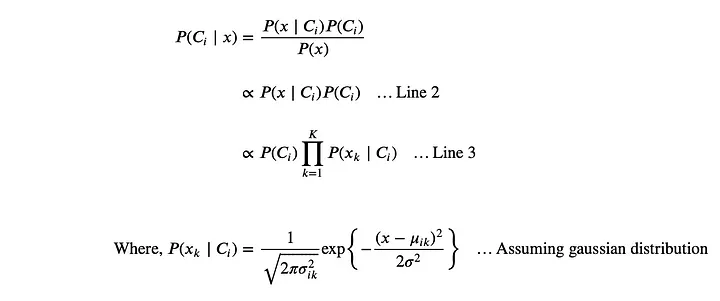


In [34]:
def distribution(x, mean, std):
        
        exponent = np.exp(-((x-mean)**2 / (2*std**2)))

        return exponent / (np.sqrt(2*np.pi)*std)


### Predict the class

In [54]:
def predict(X,class_summary):
    
        MAPs = []# Maximum a posteriori (MAP)

        for row in X:
            joint_proba = {}
            
            for class_name, features in class_summary.items():
                total_features =  len(features['summary'])
                likelihood = 1

                for idx in range(total_features):
                    feature = row[idx]
                    mean = features['summary'][idx]['mean']
                    stdev = features['summary'][idx]['std']
                    normal_proba = distribution(feature, mean, stdev)
                    likelihood *= normal_proba
                prior_proba = features['prior_proba']
                joint_proba[class_name] = prior_proba * likelihood

            MAP = max(joint_proba, key= joint_proba.get)
            MAPs.append(MAP)

        return MAPs

In [36]:
 def accuracy(y_test, y_pred):

        true_true = 0

        for y_t, y_p in zip(y_test, y_pred):
            if y_t == y_p:
                true_true += 1 
        return true_true / len(y_test)

In [83]:
def train_test_split(X, Y, split):

    #split=size of test dataset
    #randomly assigning split% rows to training set and rest to test set
    indices = np.array(range(len(X)))
    
    train_size = round((1-split) * len(X))

    random.shuffle(indices)

    train_indices = indices[0:train_size]
    test_indices = indices[train_size:len(X)]

    X_train = X.iloc[train_indices, :]
    X_test = X.iloc[test_indices, :]
    Y_train = Y.iloc[train_indices]
    Y_test = Y.iloc[test_indices]
    
    return np.asarray(X_train),np.asarray(X_test),np.asarray(Y_train),np.asarray(Y_test)

In [84]:
X_train,x_test,Y_train,y_test=train_test_split(X,Y,split=0.2)

In [55]:
class_summary=fit(X_train,Y_train) 

In [56]:
pred=predict(x_test,class_summary)

<ipython-input-34-3ec99afc63e6>:3: RuntimeWarning: invalid value encountered in double_scalars
  exponent = np.exp(-((x-mean)**2 / (2*std**2)))


## K-Nearest Neighbours implementation

In [113]:
def euclidian_distance(a, b):
    
    return np.sqrt(np.sum((a-b)**2, axis=1))## Calculates the euclidian distance

In [89]:
x_test

array([[3, 0, 20.0, ..., 0, 7.8542, 2],
       [3, 0, 22.0, ..., 0, 7.25, 2],
       [2, 0, 50.0, ..., 0, 13.0, 2],
       ...,
       [3, 0, 29.666, ..., 0, 7.7875, 2],
       [3, 0, 29.666, ..., 0, 14.4583, 2],
       [2, 0, 57.0, ..., 0, 12.35, 2]], dtype=object)

### return top k closest neigbours distance and their index

In [105]:
def K_neigbours(X_inp,K=3):
    dist=[]
    neigh_ind=[]
    distances=[euclidian_distance(x, x_train) for x in X_inp]
    #return distances
    for d in distances:
        enum_neigh = enumerate(d)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:K]
        ind_list = [x[0] for x in sorted_neigh]
        dist_list = [x[1] for x in sorted_neigh]
    
        dist.append(dist_list)
        neigh_ind.append(ind_list)
    return dist,neigh_ind
              

### return the most frequent number in the list

In [106]:
def most_frequent(List):
    unique, counts = np.unique(List, return_counts=True)
    index = np.argmax(counts)
    return unique[index]

### Predict the labels

In [107]:
def predict_neighbours(x,y_train):
    dist,neigh=K_neigbours(x,K=5)
    pred=[]
    for row in neigh:
        labels=y_train[row]
        pred.append(most_frequent(labels))
    return pred
        
        

In [112]:
pred_neighbours

[0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0]

In [114]:
accuracy(y_test,pred_neighbours)

0.5730337078651685